<a href="https://colab.research.google.com/github/Geoffysicist/skewt/blob/refactor/f160.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# f160.ipynb
Create an F160 (skewT - logP) diagram from [BUFR 309052](https://vocabulary-manager.eumetsat.int/vocabularies/BUFR/WMO/32/TABLE_D/309052) sounding data.

In [38]:
#@title Set up the environment
!pip install -q pybufrkit
!pip install -q metpy

import pandas as pd
import numpy as np
from pandas.core.frame import DataFrame
from ipywidgets import FileUpload
from IPython.display import display
from traitlets.traitlets import Dict

from pybufrkit.decoder import Decoder
from pybufrkit.dataquery import NodePathParser, DataQuerent
from pybufrkit.bufr import BufrMessage
from pybufrkit.renderer import FlatJsonRenderer

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units, pandas_dataframe_to_unit_arrays

BUFR_CODES_303054 = {
  'time_offset': '004086', # Long time period or displacement (s)
  'pressure': '007004', # Pressure (Pa)
  'gph': '010009', # Geopotential height (m)
  'lat_offset': '005015', # Latitude displacement (high accuracy) (deg)
  'long_offset': '006015', # Longitude displacement (high accuracy) (deg)
  'temp': '012101', # Temperature/air temperature (K)
  'dewpoint': '012103', # Dewpoint temperature (K)
  'wind_dir': '011001', # Wind direction (degree true)
  'wind_speed': '011002', # Wind speed (m/s)
}

UNITS = {
  'time_offset': units.second, # Long time period or displacement (s)
  'pressure': units.pascal, # Pressure (Pa)
  'gph': units.metre, # Geopotential height (m)
  'lat_offset': units.degree_E, # Latitude displacement (high accuracy) (deg)
  'long_offset': units.degree_N, # Longitude displacement (high accuracy) (deg)
  'temp': units.kelvin, # Temperature/air temperature (K)
  'dewpoint': units.kelvin, # Dewpoint temperature (K)
  'wind_dir': units.degree_E, # Wind direction (degree true)
  'wind_speed': units.meter / units.second, # Wind speed (m/s)  
}


In [39]:
#@title Define the functions
def decode_BUFR(file_upload: FileUpload) -> BufrMessage:
  """Decodes the raw BUFR file."""
  for uploaded_filename in file_upload.value:
      data_stream = file_upload.value[uploaded_filename]['content'] 
  return Decoder().process(data_stream)

def query_BUFR(message: BufrMessage) -> DataFrame:
  """ Reads data from BUFR message into a dataframe."""

  readings = {}
  for key, code in BUFR_CODES_303054.items():
    data = DataQuerent(NodePathParser()).query(message, f'303054/{code}')
    readings[key] = FlatJsonRenderer().render(data)[0]

  readings_df = pd.DataFrame.from_dict(readings)
  # clean the data
  readings_df = readings_df.dropna() # remove rows with missing data
  readings_df = readings_df.drop_duplicates(subset="pressure") # need monotonically increasing pressure
  return readings_df

def barbs_get(readings: dict, diff: int=2000) -> tuple:
  p_barbs = [] * units.pascal
  u_barbs = [] * units.meter / units.second
  v_barbs = [] * units.meter / units.second
  p_last = 999999 * units.pascal
  diff = diff * units.pascal
  u, v = mpcalc.wind_components(readings['wind_speed'], readings['wind_dir'])
  for i, p in enumerate(readings['pressure']):
    if (p_last - p) >= diff:
      p_barbs = np.append(p_barbs, p)
      u_barbs = np.append(u_barbs, u[i])
      v_barbs = np.append(v_barbs, v[i])
      p_last = p
  return p_barbs, u_barbs, v_barbs

In [40]:
#@title Upload the BUFR data
uploads = FileUpload(accept='.bfr', multiple=True)
display(uploads)

FileUpload(value={}, accept='.bfr', description='Upload', multiple=True)

In [42]:
#@title Process the data
#create the dataframes
bufr_message = decode_BUFR(uploads)
readings_df = query_BUFR(bufr_message)
readings = pandas_dataframe_to_unit_arrays(readings_df, UNITS)
T_0 = readings['temp'][0]
Td_0 = readings['dewpoint'][0]
lcl_pressure, lcl_temperature = mpcalc.lcl(readings['pressure'][0],T_0, Td_0)
parcel_prof = mpcalc.parcel_profile(readings['pressure'], T_0, Td_0).to('degC')
u, v = mpcalc.wind_components(readings['wind_speed'], readings['wind_dir'])

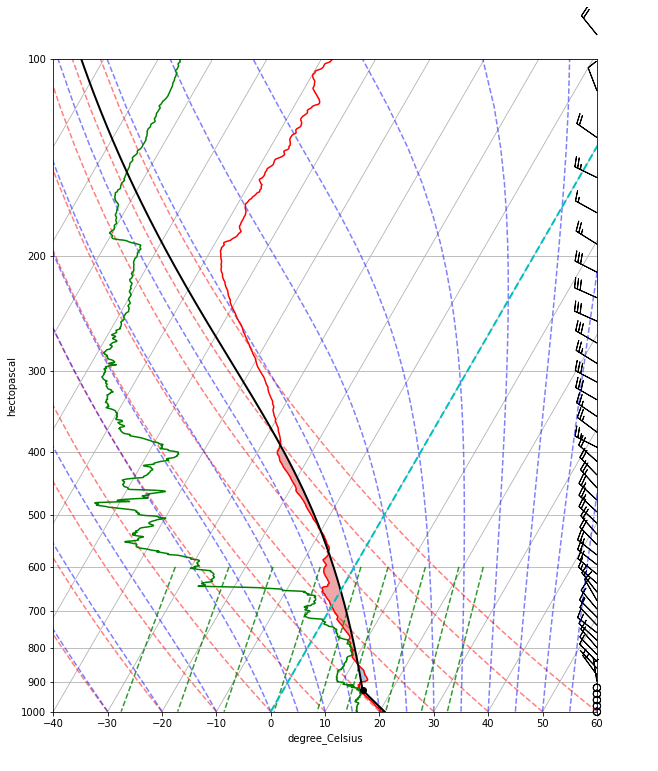

In [43]:
#@title Create and display diagram
# Create the skewT-logP diagram
fig = plt.figure(figsize=(12, 12))
skew = SkewT(fig, rotation=30, aspect=120)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(readings['pressure'], readings['temp'], 'r')
skew.plot(readings['pressure'], readings['dewpoint'], 'g')
skew.plot_barbs(*barbs_get(readings))
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
profile_plot, = skew.plot(readings['pressure'], parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(readings['pressure'], readings['temp'], parcel_prof, readings['dewpoint'])
skew.shade_cape(readings['pressure'], readings['temp'], parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# plt.show()

In [37]:
#@title Adjust Air Parcel Parameters
from ipywidgets import FloatSlider
from IPython.display import display
T_0 = np.float64(readings['temp'][0].to('degC'))
Td_0 = np.float64(readings['dewpoint'][0].to('degC'))
t_0_slider = FloatSlider(description = 'Temp', value=T_0, min=-10, max=50)
td_0_slider = FloatSlider(description = 'Dewpoint', value=Td_0, min=-10, max=50)

# def t_slider_change(val):
#   # T_0 = val
#   T_O = t_0_slider.value 
#   print(f"{T_0}")

# t_0_slider.observe(t_slider_change, names='value')

display(t_0_slider, td_0_slider)

FloatSlider(value=20.980000000000018, description='Temp', max=50.0, min=-10.0)

FloatSlider(value=15.79000000000002, description='Dewpoint', max=50.0, min=-10.0)

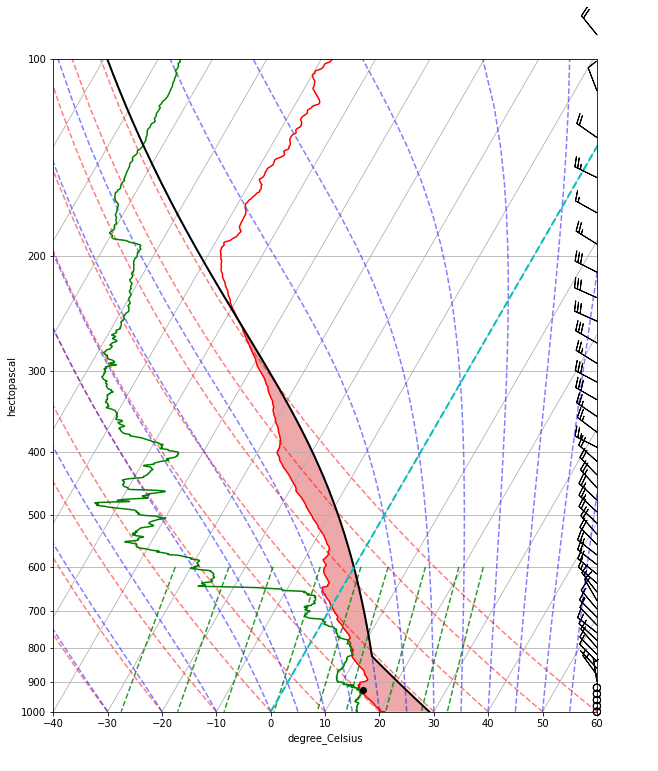

In [44]:
#@title Create and display diagram based on adjusted air parcel
T_0 = t_0_slider.value * units.degC
Td_0 = td_0_slider.value * units.degC
parcel_prof = mpcalc.parcel_profile(readings['pressure'], T_0, Td_0).to('degC')
# profile_plot.set_xdata(parcel_prof)

# Create the skewT-logP diagram
fig = plt.figure(figsize=(12, 12))
skew = SkewT(fig, rotation=30, aspect=120)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(readings['pressure'], readings['temp'], 'r')
skew.plot(readings['pressure'], readings['dewpoint'], 'g')
skew.plot_barbs(*barbs_get(readings))
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
profile_plot, = skew.plot(readings['pressure'], parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(readings['pressure'], readings['temp'], parcel_prof, readings['dewpoint'])
skew.shade_cape(readings['pressure'], readings['temp'], parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
